In [114]:
from web3 import Web3
import pandas as pd
import datetime
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from datetime import datetime
import logging, os, json
import matplotlib.pyplot as plt

In [115]:
key_1 = "4d08ab7e29294be397e15ec5503401ca"
key_2 = "d4d8ddd18ef6438ea49fd3d5006b7eba"
key_3 = "b7b06ad6a7304e2197efa10b79e1c867"
key_4 = "58bce48fe80b451c96fee8ef35bbcce8"

provider = "https://mainnet.infura.io/v3/"

In [117]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = 'block_data'
pkl_file_path = os.path.join(data_dir, 'ethereum_transactions.pkl')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

        
def save_transactions_to_pkl(block_number, transactions_data):
    """Process and save block transaction data directly to a .pkl file."""
    try:
        if os.path.exists(pkl_file_path):
            df_existing = pd.read_pickle(pkl_file_path)
        else:
            df_existing = pd.DataFrame()

        for transaction in transactions_data:
            if 'timestamp' in transaction and isinstance(transaction['timestamp'], datetime):
                transaction['timestamp'] = transaction['timestamp'].isoformat()
            
            for key, value in transaction.items():
                if isinstance(value, np.int64):
                    transaction[key] = int(value)
                    
        df_new_transactions = pd.DataFrame(transaction)

        df_combined = pd.concat([df_existing, df_new_transactions], ignore_index=True)

        df_combined.to_pickle(pkl_file_path)
        logging.info(f"Block {block_number} transactions added to the .pkl file.")
    except Exception as e:
        logging.error(f"Error processing transactions for block {block_number}: {e}")


def load_block_data(block_number):
    """Check if block transaction data exists as a .pkl file."""
    file_path = os.path.join(data_dir, f'{block_number}.json')
    if os.path.exists(file_path):
        print(f'Block {block_number} data already exists')
        return True
    return False


provider_alchemy = "https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY"

w3 = Web3(Web3.HTTPProvider(provider + key_1))
start_block = 18938321
end_block   = 18993488


transactions_data = []
block_range = np.arange(start_block, end_block + 1)
filtered_block_range = [block for block in block_range if not load_block_data(block)]

print(len(filtered_block_range)/len(block_range)*100,"% of blocks are new")

for block_number in filtered_block_range:
    block_number_int = int(block_number)
    block = w3.eth.get_block(block_number_int, full_transactions=True)
    block_timestamp = datetime.utcfromtimestamp(block.timestamp)
    
    for tx in block.transactions:
        tx_receipt = w3.eth.get_transaction_receipt(tx.hash)
        
        transactions_data.append({
            'block_number': block_number,
            'tx_hash': tx.hash.hex(),
            'gas_price': tx.gasPrice,
            'gas_used': tx_receipt.gasUsed,
            'timestamp': block_timestamp
        })
    
    
    
    #save_block_data(block_number, transactions_data)

print("Dataframe saved. Number of transactions:", len(transactions_data))

df_transactions = pd.DataFrame(transactions_data)

df_transactions['gas_price_gwei'] = df_transactions['gas_price'].apply(lambda x: w3.from_wei(x, 'gwei')).astype(int)
df_transactions['tx_hash']        = df_transactions['tx_hash'].astype(str)
df_transactions['timestamp']      = pd.to_datetime(df_transactions['timestamp'])
df_transactions = df_transactions.set_index('timestamp').sort_index()

df_transactions.to_pickle('ethereum_transactions.pkl')

Block 18938321 data already exists
99.9981873549884 % of blocks are new


HTTPError: 401 Client Error: Unauthorized for url: https://mainnet.infura.io/v3/4d08ab7e29294be397e15ec5503401ca

In [10]:
def process_json_file(file_path):
    """Read a JSON file and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    df['gas_price_gwei'] = df['gas_price'].apply(lambda x: Web3.from_wei(x, 'gwei'))
    return df

def save_df_to_csv(df, pkl_file_path):
    """Append a DataFrame to a .csv file, creating the file if it doesn't exist."""
    if os.path.exists(pkl_file_path):
        df.to_csv(pkl_file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(pkl_file_path, mode='w', header=True, index=False)

directory = 'block_data'
pkl_file_path = os.path.join(directory, 'compiled_eth_tx_small.csv')
batch_size = 50

all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json')]
all_files.sort()  # Optional: sort files if you need to process them in a specific order

for i in range(0, len(all_files), batch_size):
    batch_files = all_files[i:i+batch_size]
    frames = [process_json_file(file_path) for file_path in batch_files]
    df_batch = pd.concat(frames, ignore_index=True)
    df_batch['timestamp'] = pd.to_datetime(df_batch['timestamp'])
    save_df_to_csv(df_batch, pkl_file_path)
    print(f"Processed and saved batch {i//batch_size + 1}/{(len(all_files) - 1)//batch_size + 1}")

print("All data processed and saved.")


Processed and saved batch 1/1
All data processed and saved.


In [5]:
from web3 import Web3

provider_alchemy = "https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY"
web3 = Web3(Web3.HTTPProvider(provider_alchemy))

# # Accessing the transaction pool (this is Geth-specific and might not work with other node types)

# txpool_content = web3.geth.txpool.content()

# # Extracting transactions and their gas prices
# for txn_hash, txn_details in txpool_content['pending'].items():
#     for nonce, txn in txn_details.items():
#         print(f"Transaction Hash: {txn_hash}, Gas Price: {txn['gasPrice']} Wei")


pending_block = web3.eth.get_block('pending')

pending_transactions_count = len(pending_block.transactions)

print(f"Number of pending transactions: {pending_transactions_count}")


Number of pending transactions: 48


In [13]:
web3.geth.admin.node_info()

HTTPError: 400 Client Error: Bad Request for url: https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY

In [11]:
web3.geth.txpool.content()

HTTPError: 400 Client Error: Bad Request for url: https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY

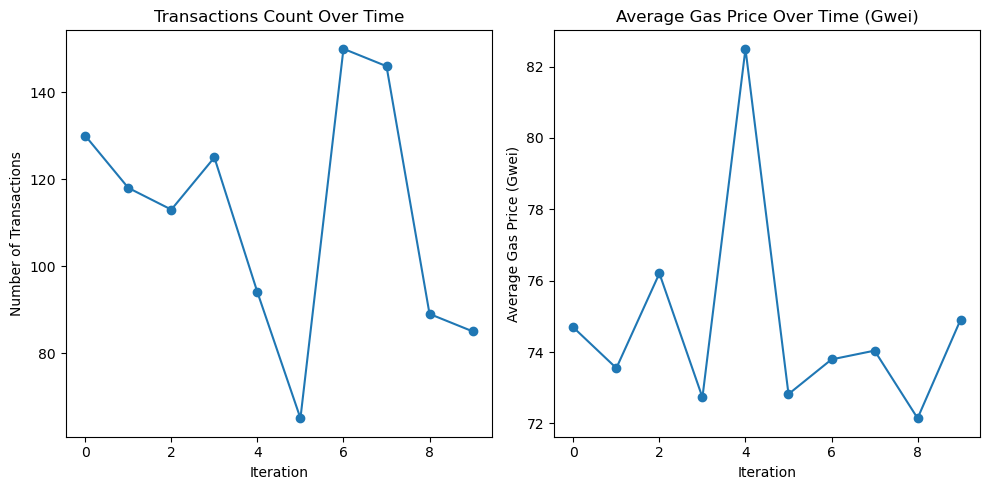

In [8]:
import time
import matplotlib.pyplot as plt
from web3 import Web3

provider_alchemy = "https://eth-mainnet.g.alchemy.com/v2/lv9CnJ8RqVk9hp-KRG2X_RS8wx3bNJbY"
web3 = Web3(Web3.HTTPProvider(provider_alchemy))

def fetch_new_transactions(previous_transactions):
    """Fetch new transactions within a given interval."""
    current_block = web3.eth.get_block('pending', full_transactions=True)
    current_transactions = current_block['transactions']
    new_transactions = [tx for tx in current_transactions if tx.hash not in previous_transactions]
    return new_transactions, current_transactions

def analyze_transactions(interval=60, iterations=10):
    """Analyze transactions over specified intervals and iterations."""
    transaction_counts = []
    average_gas_prices = []
    previous_transactions = set()

    for _ in range(iterations):
        start_time = time.time()
        
        new_transactions, current_transactions = fetch_new_transactions(previous_transactions)
        previous_transactions = {tx.hash for tx in current_transactions}

        if new_transactions:
            gas_prices = [tx.gasPrice for tx in new_transactions]
            avg_gas_price = sum(gas_prices) / len(gas_prices)
        else:
            avg_gas_price = 0
        
        transaction_counts.append(len(new_transactions))
        average_gas_prices.append(avg_gas_price)

        time_to_wait = interval - (time.time() - start_time)
        if time_to_wait > 0:
            time.sleep(time_to_wait)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(iterations), transaction_counts, marker='o')
    plt.title('Transactions Count Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Transactions')

    plt.subplot(1, 2, 2)
    plt.plot(range(iterations), [price / 1e9 for price in average_gas_prices], marker='o')  # Convert Wei to Gwei
    plt.title('Average Gas Price Over Time (Gwei)')
    plt.xlabel('Iteration')
    plt.ylabel('Average Gas Price (Gwei)')

    plt.tight_layout()
    plt.show()

# Example usage
analyze_transactions(interval=10, iterations=10)
